##

In [57]:
import matplotlib.pyplot as plt

In [2]:
import sagemaker
import boto3
import os

from skimage.io import imread
from skimage import img_as_ubyte
import numpy as np

In [3]:
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.pytorch import PyTorch
from sagemaker.pytorch.model import PyTorchModel

In [4]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import IPython

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-03-29 00:40:24.405 pytorch-1-13-cpu-py39-ml-m5-large-e240dbf4b804946d7c5723319b3e:24 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [5]:
bucket= 'udacity-mle-capstone'
print("Default Bucket: {}".format(bucket))
region = 'us-east-2'
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: udacity-mle-capstone
AWS Region: us-east-2
RoleArn: arn:aws:iam::085616114435:role/service-role/AmazonSageMaker-ExecutionRole-20221221T205295


## Train initial model with profiling and debugging

In [9]:
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [19]:
estimator = PyTorch(
    entry_point='train_model.py',
    role=role,
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    framework_version="1.8",
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
    py_version="py36",
    source_dir="code"
)

In [20]:
estimator.fit({'train':'s3://udacity-mle-capstone/train/',
               'test':'s3://udacity-mle-capstone/test/',
               'meta':'s3://udacity-mle-capstone/meta/'
              }, 
              wait=True)

2023-03-28 19:29:22 Starting - Starting the training job...
2023-03-28 19:29:38 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-03-28 19:30:47 Downloading - Downloading input data...
2023-03-28 19:31:21 Training - Downloading the training image...
2023-03-28 19:31:48 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-28 19:31:44,437 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-28 19:31:44,440 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-28 19:31:44,448 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-

In [23]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
#print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
#print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

tj = TrainingJob(training_job_name, 'us-east-2')
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

Training jobname: pytorch-training-2023-03-28-19-29-21-822
Region: us-east-1
[2023-03-28 20:35:48.779 1-8-1-cpu-py36-ml-t3-medium-b1e105fab0ca332569ae17f8727f:49 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-2-085616114435/pytorch-training-2023-03-28-19-29-21-822/debug-output
[2023-03-28 20:35:49.052 1-8-1-cpu-py36-ml-t3-medium-b1e105fab0ca332569ae17f8727f:49 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-28 20:35:50.071 1-8-1-cpu-py36-ml-t3-medium-b1e105fab0ca332569ae17f8727f:49 INFO trial.py:210] Loaded all steps
['BCELoss_output_0', 'gradient/SiameseNetwork_fc.0.bias', 'gradient/SiameseNetwork_fc.0.weight', 'gradient/SiameseNetwork_fc.2.bias', 'gradient/SiameseNetwork_fc.2.weight', 'gradient/SiameseNetwork_resnet.0.weight', 'gradient/SiameseNetwork_resnet.1.bias', 'gradient/SiameseNetwork_resnet.1.weight', 'gradient/SiameseNetwork_resnet.4.0.bn1.bias', 'gradient/SiameseNetwork_resnet.4.0.bn1.weight', 'gradient/S

You will find the profiler report in s3://sagemaker-us-east-2-085616114435/pytorch-training-2023-03-28-19-29-21-822/rule-output
2023-03-28 20:27:44     386481 pytorch-training-2023-03-28-19-29-21-822/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-28 20:27:43     236531 pytorch-training-2023-03-28-19-29-21-822/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-28 20:27:39        192 pytorch-training-2023-03-28-19-29-21-822/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-28 20:27:39        200 pytorch-training-2023-03-28-19-29-21-822/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-28 20:27:39       1826 pytorch-training-2023-03-28-19-29-21-822/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-28 20:27:39        127 pytorch-training-2023-03-28-19-29-21-822/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.jso

In [24]:
estimator.jobs[-1].describe()

{'TrainingJobName': 'pytorch-training-2023-03-28-19-29-21-822',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:085616114435:training-job/pytorch-training-2023-03-28-19-29-21-822',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-2-085616114435/pytorch-training-2023-03-28-19-29-21-822/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"pytorch-training-2023-03-28-19-29-21-822"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-2"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-085616114435/pytorch-training-2023-03-28-19-29-21-822/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-training:1.8-cpu-py36',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetricsTimeSeries': True},
 'RoleArn': 'arn:aws:iam::085616114435:role/service-role/A

## Hyperparameter tuning

In [6]:
estimator = PyTorch(
    entry_point='train_model.py',
    role=role,
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    #hyperparameters=hyperparameters,
    framework_version="1.8",
    #profiler_config=profiler_config,
    #debugger_hook_config=debugger_config,
    #rules=rules,
    py_version="py36",
    source_dir="code"
)

In [11]:
hyperparameter_ranges = {
    "train-batch-size": CategoricalParameter([64, 128]),
    "lr": CategoricalParameter([0.1, 1.0])
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type
)

In [12]:
tuner.fit({'train':'s3://udacity-mle-capstone/train/',
               'test':'s3://udacity-mle-capstone/test/',
               'meta':'s3://udacity-mle-capstone/meta/'
              }, 
              wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [13]:
tuner.best_training_job()

'pytorch-training-230329-0057-002-c72bac2b'

In [14]:
best_estimator = tuner.best_estimator()


2023-03-29 01:53:21 Starting - Preparing the instances for training
2023-03-29 01:53:21 Downloading - Downloading input data
2023-03-29 01:53:21 Training - Training image download completed. Training in progress.
2023-03-29 01:53:21 Uploading - Uploading generated training model
2023-03-29 01:53:21 Completed - Resource released due to keep alive period expiry


In [15]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'lr': '"0.1"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-29-00-57-13-692"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_region': '"us-east-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-085616114435/pytorch-training-2023-03-29-00-57-13-692/source/sourcedir.tar.gz"',
 'train-batch-size': '"128"'}

In [31]:
best_estimator.model_data

's3://sagemaker-us-east-2-085616114435/pytorch-training-230329-0057-002-c72bac2b/output/model.tar.gz'

## Deploy to endpoint and run inference on pairs of images

In [46]:
estimator_trained = PyTorchModel(
    model_data = best_estimator.model_data,
    entry_point='inference.py',
    framework_version="1.8",
    py_version="py36",
    source_dir="code",
    role=role
)

In [47]:
predictor=estimator_trained.deploy(initial_instance_count=1, 
                           instance_type="ml.m5.large")

------!

In [50]:
img1 = img_as_ubyte(imread('/root/udacity-mle-capstone/project/sign_data/test/050/01_050.png', as_gray=True))
img2 = img_as_ubyte(imread('/root/udacity-mle-capstone/project/sign_data/test/050/02_050.png', as_gray=True))
img3 = img_as_ubyte(imread('/root/udacity-mle-capstone/project/sign_data/test/050_forg/02_0204050.PNG', as_gray=True))

In [84]:
response_real = predictor.predict(np.array([img1, img2], dtype='object'))[0][0]
response_forged = predictor.predict(np.array([img1, img3], dtype='object'))[0][0]

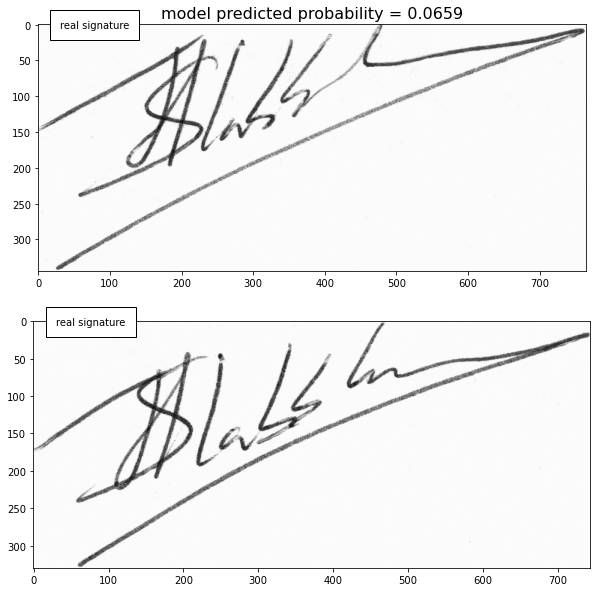

In [86]:
fig, axs = plt.subplots(2, figsize=(10, 10))
ax0,ax1 = axs
ax0.imshow(img1, cmap='binary_r', label='real')
ax1.imshow(img2, cmap='binary_r')
ax0.set_title(f'model predicted probability = {response_real:.4f}', size=16)
ax0.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10})
ax1.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10});

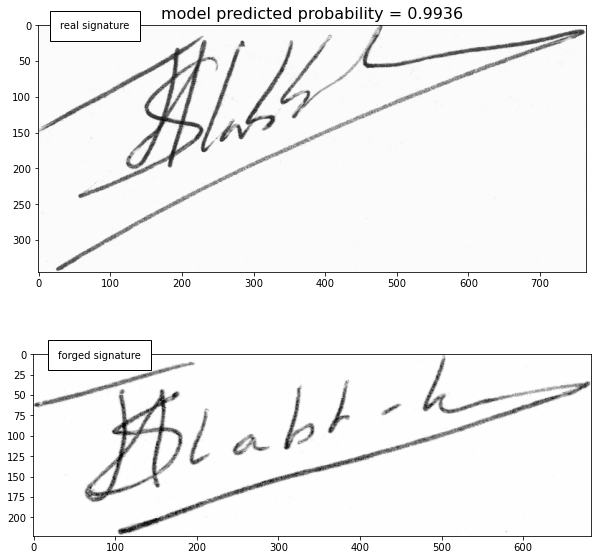

In [88]:
fig, axs = plt.subplots(2, figsize=(10, 10))
ax0,ax1 = axs
ax0.imshow(img1, cmap='binary_r')
ax1.imshow(img3, cmap='binary_r')
ax0.set_title(f'model predicted probability = {response_forged:.4f}', size=16)
ax0.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10})
ax1.text(30, 5, 'forged signature', bbox={'facecolor': 'white', 'pad': 10});

In [90]:
predictor.delete_endpoint()

ClientError: An error occurred (ValidationException) when calling the DeleteEndpointConfig operation: Could not find endpoint configuration "arn:aws:sagemaker:us-east-2:085616114435:endpoint-config/pytorch-inference-2023-03-29-03-02-13-557".